In [1]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

In [2]:
# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

# Create Graph using Bipartite Projection on Arxiv Dataset

In [27]:
data = 'data/arxiv_network_science_data.csv'

df = pd.read_csv(data)

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Dustin Nguyen,Neural ODEs as a discovery tool to characteriz...
1,Yuan-Sen Ting,Neural ODEs as a discovery tool to characteriz...
2,Todd A. Thompson,Neural ODEs as a discovery tool to characteriz...
3,Sebastian Lopez,Neural ODEs as a discovery tool to characteriz...
4,Laura A. Lopez,Neural ODEs as a discovery tool to characteriz...


In [5]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

G = nx.k_core(G, 2) # no isolates or two-node groups

In [6]:
print(G)

Graph with 59260 nodes and 302588 edges


# Community Detection + Community Analysis

There's two parts to what I am attempting today.
- I need to use community detection to identify communities in the network.
- I can then use network science and data science to identify interesting communities

By interesting, I mean not stars. I am looking for complex ecosystems. So, I will identify communities, then attempt to detect more complex ecosystems by using triangles and density.

## Community Detection

In [7]:
import community as community_louvain

partition = community_louvain.best_partition(G, resolution=0.01, random_state=1337) # 10 was good for this network

In [8]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

# remove junk; identify relevant communities

community_df['community'].value_counts()[0:20]

community
10828    186
6081     167
6852     145
3474     138
6068     128
10420    118
7329     110
6224     104
4159     102
3315     100
3625      91
3263      72
6722      71
9851      69
7878      68
6194      66
6529      64
2572      63
11085     59
7623      58
Name: count, dtype: int64

In [9]:
community_node_counts = community_df['community'].value_counts()

community_size_df = pd.DataFrame(community_node_counts).reset_index()
community_size_df.columns = ['community', 'node_count']

# just to speed up this experiment
community_size_df = community_size_df[community_size_df['node_count'] > 10]

community_size_df.head()

,community,node_count
0,10828,186
1,6081,167
2,6852,145
3,3474,138
4,6068,128


In [10]:
community_size_df.shape

(743, 2)

## Capture Community Context

In [11]:
community_df.head()

,node,community
0,Dustin Nguyen,2
1,Yuan-Sen Ting,393
2,Todd A. Thompson,2
3,Sebastian Lopez,2
4,Laura A. Lopez,2


In [12]:
community_size_df.head(1)

,community,node_count
0,10828,186


In [13]:
def get_community_nodes(community_df, community):

    return sorted(community_df[community_df['community']==community]['node'].values)

In [14]:
def get_community_context(community_size_df, community_df, G):

    G = G.copy()

    communities = {}

    for row in community_size_df.iterrows():

        data = row[1]
        community = data['community']
        node_count = data['node_count']
        
        nodes = get_community_nodes(community_df, community)
        G_sub = G.subgraph(nodes)

        # starting with density today; will add on more context later
        density = nx.density(G_sub)
        
        communities[community] = {}

        communities[community]['G'] = G_sub
        communities[community]['density'] = density
        
    return communities

In [15]:
community_context_dict = get_community_context(community_size_df, community_df, G)

In [16]:
community_context_df = pd.DataFrame(community_context_dict).T.reset_index()
community_context_df.columns = ['community', 'G', 'density']

community_context_df.head()

,community,G,density
0,10828,"(Do-Heung Je, Noriyuki Kawaguchi, Phrudth Jaro...",0.343156
1,6081,"(J. Qin, F. Semeria, K. Abe, P. Gaemers, B. An...",1.0
2,6852,"(J. Cvach, R. C. W. Henderson, A. Baghdasaryan...",1.0
3,3474,"(O. Pyshna, N. Guessoum, A. Coleiro, T. Dietri...",0.879509
4,6068,"(Yves Dirian, Maria Alessandra Papa, Andrew Ma...",0.61159


<Axes: ylabel='Frequency'>

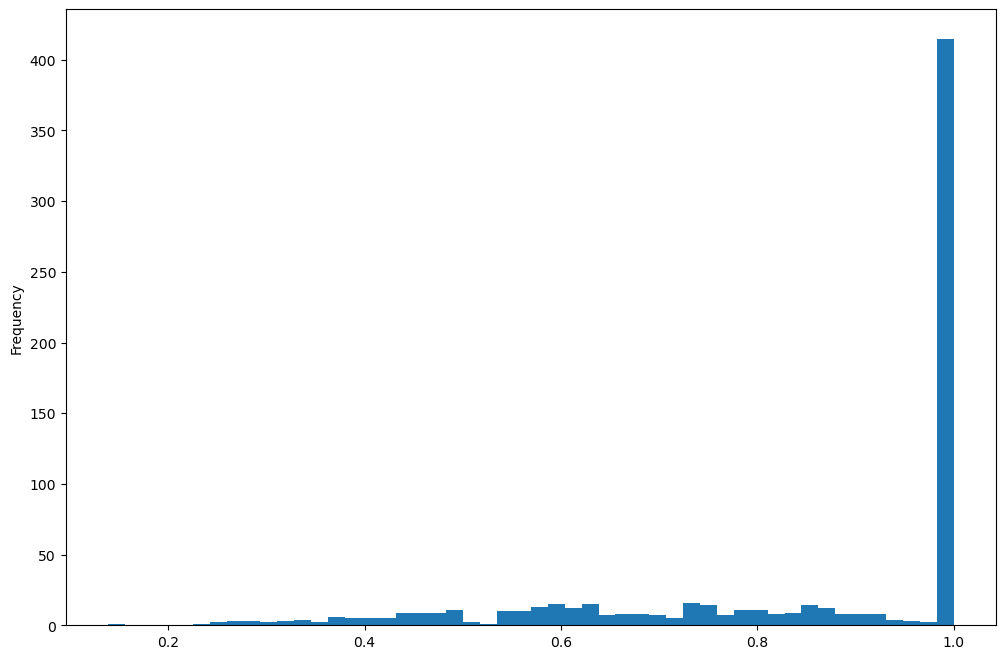

In [17]:
community_context_df['density'].plot.hist(bins=50, figsize=(12,8))

#### Investigate Communities

For this quick experiment, I want to just see subgraphs that have a density of 0.4 or above. 

But I want communities with a density of less than 0.8. I don't want fully connected communities or too densely connected.

In [19]:
mask = (community_context_df['density']>0.4) & (community_context_df['density']<0.8)

community_context_df[mask]['community'].values[0:10]

array([ 6068, 10420,  7329,  7878,  2572, 11085,  6616,  3613,  2371,
        1376], dtype=int64)

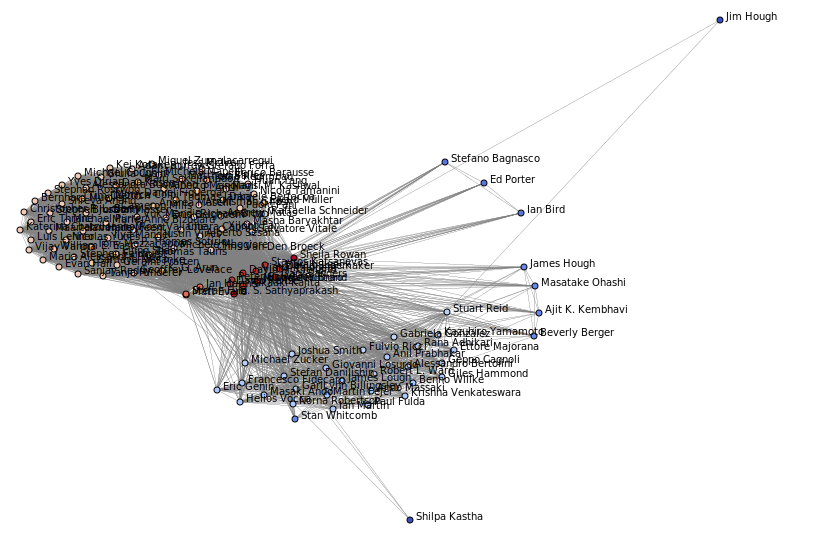

In [21]:
community = 6068

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

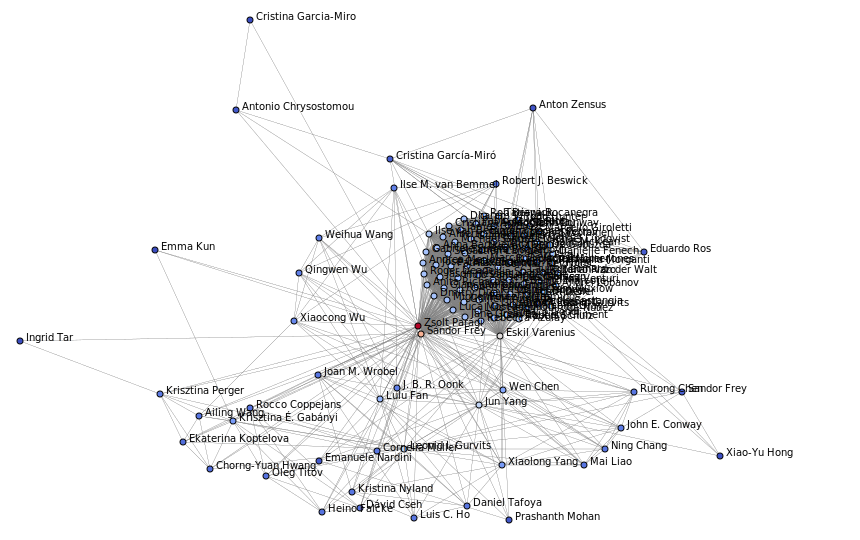

In [22]:
community = 10420

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

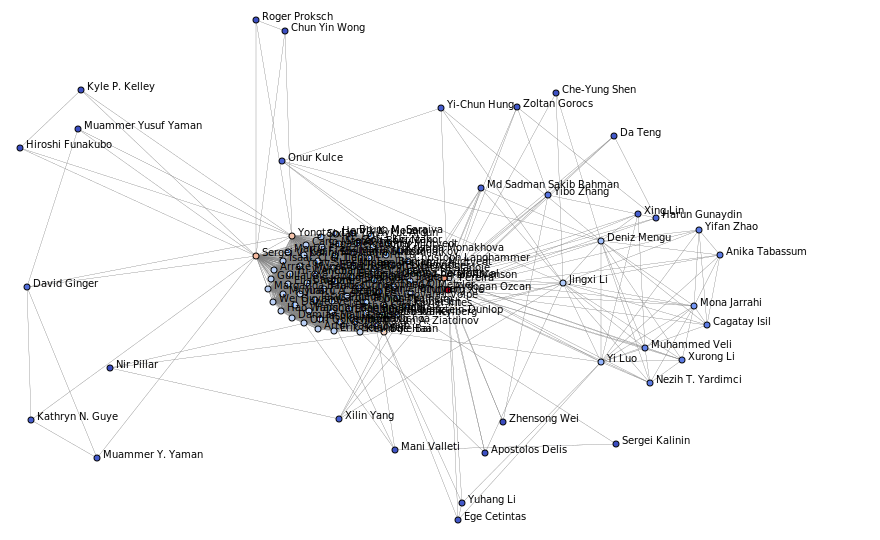

In [23]:
community = 7329

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

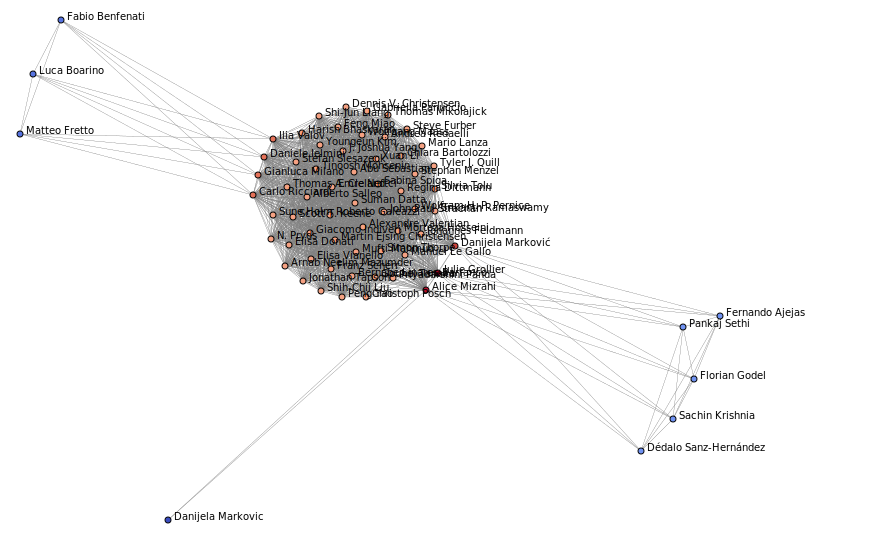

In [24]:
community = 7878

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

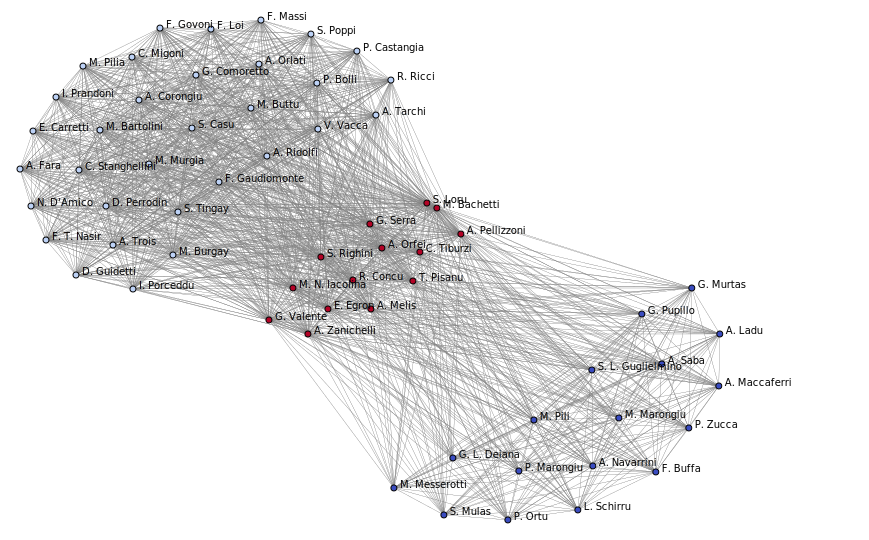

In [25]:
community = 2572

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)

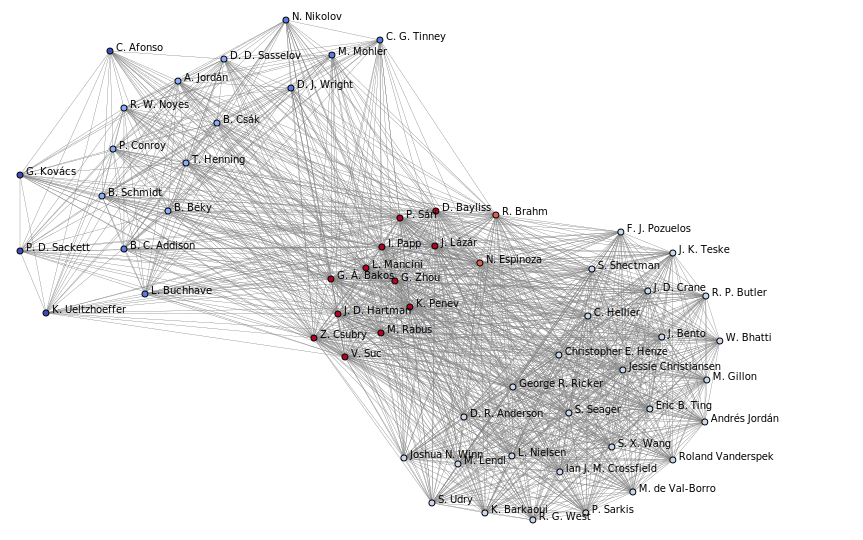

In [26]:
community = 11085

G_check = community_context_dict[community]['G']
draw_graph(G_check, show_names=True, node_size=3, edge_width=0.2)